### Minimal examples for testing purposes

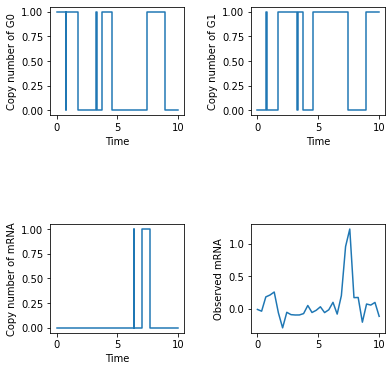

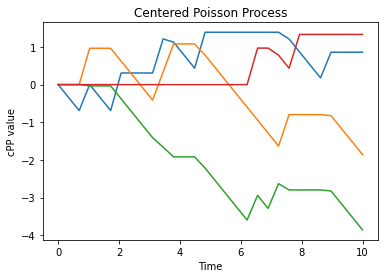

In [1]:
import pandas as pd
from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
import numpy as np
import matplotlib.pyplot as plt  
from tqdm import tqdm
import torch


### Constructing the gene expression model G0 <-> G1 -> mRNA -> nothing

species_names = ['G0', 'G1', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0],
                         [1, -1, 0, 0],
                         [0, 0, 1,-1]]
parameters_names = ['k1','k2', 'kp1']
reaction_names = ['G Act. 1', 'G Deg. 1', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda kp1, G1: kp1*G1,
    lambda mRNA: mRNA
]

# species parameters ranges 
range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 120] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 100], [0, 100], [0, 150]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 151], index=parameters_names) #index=parameters_names


h_function = [
    lambda mRNA: mRNA # np.where(mRNA > 5, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 0.1
]

MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function)

# simulate once
parameter_values = {'k1': 1, 'k2': 1, 'kp1': 1}
initial_state = {'G0': 1, 'G1': 0, 'mRNA': 0}
tf = 10


time_list, state_list, cPP = MI.SSA(initial_state, parameter_values, 0, tf, compute_centered_poisson_process=True)
MI.plot_trajectories(time_list, state_list)

# Generate the observations
n_samples = 30
Observation_times_list = np.linspace(0, tf, n_samples)
Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)
plt.plot(Observation_times_list, Y_list)
plt.ylabel('Observed mRNA')
plt.show()

cPP.plot(Observation_times_list)

### Testing batch generation

In [2]:
from ElenaDataManagement import count_samples_for_supersampling, get_X_Y_sampling_times, sample_trajectory_on_times, CRN_simulations_to_dataloaders, run_SSA_for_filtering

# testing count_samples_for_supersampling (x,y) -> (x-1)*y + y
assert count_samples_for_supersampling(10, 1) == 19
assert count_samples_for_supersampling(125, 5) == 124*5 + 125

# testing get_X_Y_sampling_times
forX, forY = get_X_Y_sampling_times(0, 10, 11, 1)
assert len(forX) == 21
assert len(forY) == 11
forX, forY = get_X_Y_sampling_times(1, 10, 11, 2)
assert len(forX) == 31
assert len(forY) == 11

print(forX)
print(forY)

[ 1.   1.3  1.6  1.9  2.2  2.5  2.8  3.1  3.4  3.7  4.   4.3  4.6  4.9
  5.2  5.5  5.8  6.1  6.4  6.7  7.   7.3  7.6  7.9  8.2  8.5  8.8  9.1
  9.4  9.7 10. ]
[ 1.   1.9  2.8  3.7  4.6  5.5  6.4  7.3  8.2  9.1 10. ]


In [3]:
sample_trajectory_on_times([1,3,5,7,9], np.linspace(0, 10, (11)), np.linspace(0, 1, (11))*2+1)


[1.2, 1.6, 2.0, 2.4000000000000004, 2.8]

In [4]:
np.linspace(0, 10, (11))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [5]:
np.linspace(0, 1, (11))*2+1

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

In [6]:
n_samples = 10 # p in the paper
batch_size = 2 #int(math.sqrt(n_samples))

n_Y_measurements = 11 # n in the paper
n_X_measurements_between_Y_measurements = 1 # m_bar-2 in the paper

dataset = run_SSA_for_filtering(MI, initial_state, parameter_values, tf, n_Y_measurements, n_X_measurements_between_Y_measurements, n_samples=n_samples)

100%|██████████| 10/10 [00:00<00:00, 193.26it/s]


In [7]:
assert (dataset["times_X"] == np.linspace(0, 10, (21))).all()
assert (dataset["times_Y"] == np.linspace(0, 10, (11))).all()

In [8]:
assert len(dataset["X"]) == n_samples
assert len(dataset["Y"]) == n_samples
assert len(dataset["R"]) == n_samples
assert len(dataset["X"][0]) == 21
assert len(dataset["Y"][0]) == 11
assert len(dataset["R"][0]) == 21

[array([1., 0., 0.]), array([1., 0., 0.]), array([0., 1., 0.]), array([0., 1., 0.]), array([0., 1., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([0., 1., 0.]), array([1., 0., 0.]), array([0., 1., 0.]), array([0., 1., 0.]), array([0., 1., 1.]), array([1., 0., 0.]), array([1., 0., 0.]), array([0., 1., 1.]), array([0., 1., 2.]), array([0., 1., 0.]), array([0., 1., 0.]), array([0., 1., 0.]), array([0., 1., 1.]), array([0., 1., 0.])]
[array([-0.07777176]), array([-0.03807475]), array([-0.08443681]), array([0.22398583]), array([0.02765139]), array([-0.08382184]), array([-0.0667589]), array([1.14158929]), array([0.04737004]), array([0.12721628]), array([-0.02869318])]
[[ 0.          0.          0.          0.        ]
 [-0.5         0.          0.          0.        ]
 [ 0.37526906 -0.37526906 -0.37526906  0.        ]
 [ 0.37526906 -0.87526906 -0.87526906  0.        ]
 [ 0.37526906 -1.37526906 -1.37526906  0.        ]
 [ 0.1838538  -0.6838538  -0.6838538   0.83835334]
 [-0.3161462  -

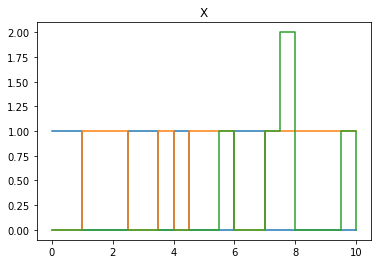

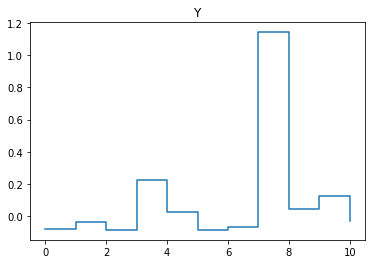

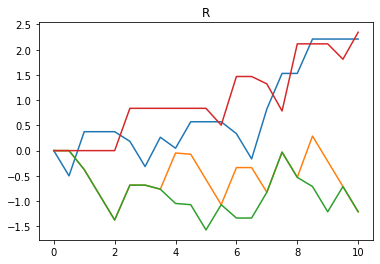

In [9]:
index = 5

print(dataset["X"][index])
print(dataset["Y"][index])
print(dataset["R"][index])

# plot stepwise
plt.step(dataset["times_X"], dataset["X"][index], where='post')
plt.title("X")
plt.show()
plt.step(dataset["times_Y"], dataset["Y"][index], where='post')
plt.title("Y")
plt.show()
plt.plot(dataset["times_X"], dataset["R"][index])
plt.title("R")
plt.show()


In [10]:
batch_size = 2
train_loader, test_loader, tX, tY = CRN_simulations_to_dataloaders(dataset, batch_size=batch_size)

# check dimensions of the batches and time lists
print([x.shape for x in next(iter(train_loader))])
print("expected:", [(batch_size, count_samples_for_supersampling(n_Y_measurements, n_X_measurements_between_Y_measurements), MI.stoichiometric_matrix.shape[0]), (batch_size, n_Y_measurements, 1), (batch_size, count_samples_for_supersampling(n_Y_measurements, n_X_measurements_between_Y_measurements), MI.stoichiometric_matrix.shape[0])])
assert len(tX) == count_samples_for_supersampling(n_Y_measurements, n_X_measurements_between_Y_measurements)
assert len(tY) == n_Y_measurements

[torch.Size([2, 21, 3]), torch.Size([2, 11, 1]), torch.Size([2, 21, 4])]
expected: [(2, 21, 3), (2, 11, 1), (2, 21, 3)]


### Double check the cPP (on the BD process)

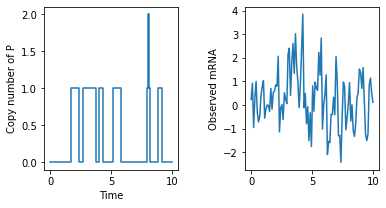

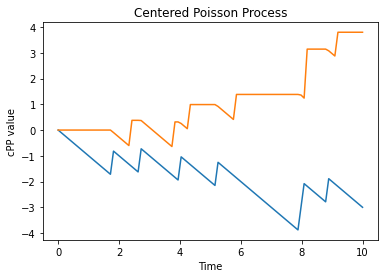

In [44]:
# birth death process

import pandas as pd
from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
import numpy as np
import matplotlib.pyplot as plt  
from tqdm import tqdm
import torch


### Constructing the gene expression model G0 <-> G1 -> mRNA -> nothing

species_names = ['P']
stoichiometric_matrix = [1, -1],
parameters_names = ['k','g']
reaction_names = ['birth', 'death']
propensities = [
    lambda k : k,
    lambda g, P: g*P,
]

# species parameters ranges 
range_of_species = \
    pd.DataFrame([[0, 120]], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 100],[0, 100]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([100, 100], index=parameters_names)


h_function = [
    lambda P: P # np.where(mRNA > 5, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 1
]

MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function)

# simulate once
parameter_values = {'k': 1, 'g': 1}
initial_state = {'P': 0}
tf = 10


time_list, state_list, cPP = MI.SSA(initial_state, parameter_values, 0, tf, compute_centered_poisson_process=True)
MI.plot_trajectories(time_list, state_list)

# Generate the observations
n_samples = 100
Observation_times_list = np.linspace(0, tf, n_samples)
Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)
plt.plot(Observation_times_list, Y_list)
plt.ylabel('Observed mRNA')
plt.show()
cPP.plot(Observation_times_list)

In [45]:
time_list

[0,
 1.7215731505534773,
 2.3434403664122714,
 2.7194187041460873,
 3.7815481228600567,
 3.9790741049677996,
 4.305001389308127,
 5.180370900013192,
 5.78673687064587,
 7.955617618072625,
 8.064443013170607,
 8.097420612035998,
 8.162352167748647,
 8.823585436376506,
 9.168123838861698,
 10]

In [46]:
state_list

[array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([2.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([0.])]

In [47]:
cPP.centered_PP

[array([0., 0.]),
 array([-0.72157315,  0.        ]),
 array([-1.34344037,  0.37813278]),
 array([-0.7194187 ,  0.37813278]),
 array([-1.78154812,  0.31600337]),
 array([-0.9790741 ,  0.31600337]),
 array([-1.30500139,  0.99007608]),
 array([-1.1803709 ,  0.99007608]),
 array([-1.78673687,  1.38371011]),
 array([-2.95561762,  1.38371011]),
 array([-2.06444301,  1.27488472]),
 array([-2.09742061,  2.20892952]),
 array([-2.16235217,  3.14399796]),
 array([-1.82358544,  3.14399796]),
 array([-2.16812384,  3.79945956]),
 array([-3.        ,  3.79945956])]

In [51]:
cPP.sample_at_times(Observation_times_list)

array([[ 0.        ,  0.        ],
       [-0.1010101 ,  0.        ],
       [-0.2020202 ,  0.        ],
       [-0.3030303 ,  0.        ],
       [-0.4040404 ,  0.        ],
       [-0.50505051,  0.        ],
       [-0.60606061,  0.        ],
       [-0.70707071,  0.        ],
       [-0.80808081,  0.        ],
       [-0.90909091,  0.        ],
       [-1.01010101,  0.        ],
       [-1.11111111,  0.        ],
       [-1.21212121,  0.        ],
       [-1.31313131,  0.        ],
       [-1.41414141,  0.        ],
       [-1.51515152,  0.        ],
       [-1.61616162,  0.        ],
       [-1.71717172,  0.        ],
       [-0.81818182, -0.09660867],
       [-0.91919192, -0.19761877],
       [-1.02020202, -0.29862887],
       [-1.12121212, -0.39963897],
       [-1.22222222, -0.50064907],
       [-1.32323232, -0.60165917],
       [-1.42424242,  0.37813278],
       [-1.52525253,  0.37813278],
       [-1.62626263,  0.37813278],
       [-0.72727273,  0.37027876],
       [-0.82828283,

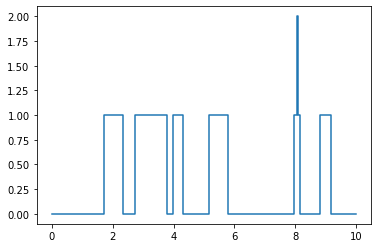

In [52]:
plt.step(time_list, state_list, where='post')

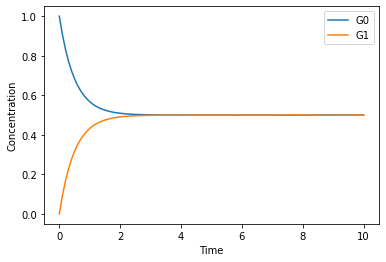

In [53]:
# solve ODE
import scipy.integrate as integrate

def ode_system(t,x, k0, k1):
    dG0 = -x[0]*k0 + x[1]*k1
    dG1 = x[0]*k0 - x[1]*k1
    return [dG0, dG1]

# Initial condition
y0 = [1,0]

# Time points
t = np.linspace(0, tf, 100)

k0 = 1
k1 = 1

# Solve the ODE
sol = integrate.solve_ivp(ode_system, t_span=(0, tf), y0=y0, t_eval=t, args=(k0, k1))

# Plot the solution
plt.plot(sol.t, sol.y[0], label='G0')
plt.plot(sol.t, sol.y[1], label='G1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()


In [56]:
1/2 + 1/2 * np.exp(-2*0.1) 

0.9093653765389909